In [54]:
import seaborn as sn
from systems import EpicActionRecogintionShapleyClassifier
from datasets.pickle_dataset import MultiPickleDataset
from models.esvs import V_MTRN, N_MTRN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
from frame_sampling import RandomSampler
import pandas as pd
from tqdm import tqdm
from collections import Counter

In [55]:
def no_collate(args):
    return args

trainloader = DataLoader(MultiPickleDataset('../datasets/epic-100/features/67217_train_features.pkl'), batch_size=1, collate_fn=no_collate, shuffle=True)
testloader = DataLoader(MultiPickleDataset('../datasets/epic-100/features/9668_val_features.pkl'), batch_size=1, collate_fn=no_collate, shuffle=False)

In [21]:
class V_MTRN(nn.Module):
    
    def __init__(self, frame_count: int):
        super().__init__()
        self.frame_count = frame_count
        self.fc1 = nn.Linear(256 * frame_count, 1024)
#         self.fc1_2 = nn.Linear(4096, 1024)
#         self.d1 = nn.Dropout(p=0.7)
        self.d2 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3_verb = nn.Linear(512, 97)
    
    def forward(self, x):
        x = x.view(-1, 256 * self.frame_count)
        x = F.relu(self.fc1(x))
#         x = self.d1(x)
#         x = F.relu(self.fc1_2(x))
        x = self.d2(x)
        x = F.relu(self.fc2(x))
        x = self.d2(x)
#         x = self.dropout(x)
        x = self.fc3_verb(x)
        
        return x

In [56]:
v_models = [V_MTRN(frame_count=i, hidden_layer_size=2048, dropout_count=2) for i in range(1,9)]
# v_model.load_state_dict(torch.load('mtrn_verb_frames=4_lr=1e-4_hl=1024_dc=2.pt', map_location='cpu'))
n_models = [N_MTRN(frame_count=i, hidden_layer_size=2048, dropout_count=2) for i in range(1,9)]
frame_samplers = [RandomSampler(frame_count=i, snippet_length=1, test=False) for i in range(1,9)]

for i in range(len(v_models)):
    try:
        v_models[i].load_state_dict(torch.load(Path('../datasets/epic-100/models/') / f'sh_mtrn-type=verb-frames={i+1}-batch_size=512-lr=1e-05_hl=2048_dc=2.pt', map_location='cpu'))
    except FileNotFoundError:
        print(f'no verb model for {i+1} frames')
    try:
        n_models[i].load_state_dict(torch.load(Path('../datasets/epic-100/models/') / f'sh_mtrn-type=noun-frames={i+1}-batch_size=512-lr=1e-05_hl=2048_dc=2.pt', map_location='cpu'))
    except FileNotFoundError:
        print(f'no noun model for {i+1} frames')

In [57]:
verbs = pd.read_csv('../datasets/epic-100/labels/EPIC_100_verb_classes.csv')['key'].to_dict()
nouns = pd.read_csv('../datasets/epic-100/labels/EPIC_100_noun_classes.csv')['key'].to_dict()

In [63]:
def get_per_class_accuracy(model, sampler):
    
    def compute_accuracy(preds, labels) -> float:
        return float((labels == preds).sum()) / len(labels)

    if isinstance(model, V_MTRN):
        classes = verbs
        m_type="verb"
    else:
        classes = nouns
        m_type="noun"

    classifier = EpicActionRecogintionShapleyClassifier(
        model,
        torch.device("cpu"),
        None,
        sampler,
        sampler,
        trainloader,
        trainloader,
        m_type
    )
    
    correct_pred = {classname: 0 for classname in classes.keys()}
    incorrect_pred = {classname: {class_n: 0 for class_n in classes.keys()} for classname in classes.keys()}
    total_pred = {classname: 0 for classname in classes.keys()}
    
#     print(correct_pred)
#     print(incorrect_pred)
#     print(total_pred)
    
    model.eval()
    with torch.no_grad():
        
        validation_results = {
            'loss': [],
            'accuracy': [],
            'preds': [],
            'labels': []
        }
            
        for idx, data in tqdm(enumerate(trainloader),total=len(trainloader),dynamic_ncols=True):
            
            batch, labels = classifier._sample_frames(data)
            
            logits = model(batch.to(torch.device('cpu')))
            preds = logits.argmax(-1).cpu().numpy()
            label_classes = labels[f'{m_type}_class']
            
#             print(f'pred: {preds}, label: {label_classes.cpu().numpy()}')

            for label, pred in zip(label_classes.cpu().numpy(), preds):
                if label == pred:
                    correct_pred[label] += 1
                incorrect_pred[label][pred] += 1
                total_pred[label] += 1
                        
            validation_results['preds'].extend(list(preds))
            validation_results['labels'].extend(list(label_classes.cpu().numpy()))
            
    validation_results['accuracy'] = compute_accuracy(
        np.array(validation_results["labels"]), 
        np.array(validation_results["preds"])
    )
        
        
    print(validation_results['accuracy'])
    
#     print(correct_pred)
#     print(incorrect_pred)
#     print(total_pred)
    
    for classname, correct in correct_pred.items():
        try:
            accuracy = 100 * float(correct) / total_pred[classname]
            print("Accuracy for class {:5s} is: {:.1f}%".format(classes[classname], accuracy))
        except ZeroDivisionError:
            print("Did not predict class {:5s}".format(classes[classname]))
            
    return classes, incorrect_pred

In [70]:
classes, incorrect_pred = get_per_class_accuracy(model=n_models[7], sampler=frame_samplers[7])

  0%|          | 1/67217 [00:00<1:56:07,  9.65it/s]

Classifier, model: <class 'models.esvs.N_MTRN'>, type: noun, frames: 8


100%|██████████| 67217/67217 [01:41<00:00, 659.83it/s] 


0.303048335986432
Accuracy for class tap   is: 72.2%
Accuracy for class spoon is: 18.2%
Accuracy for class plate is: 30.2%
Accuracy for class cupboard is: 61.8%
Accuracy for class knife is: 12.4%
Accuracy for class pan   is: 26.3%
Accuracy for class lid   is: 11.1%
Accuracy for class bowl  is: 15.5%
Accuracy for class drawer is: 53.2%
Accuracy for class sponge is: 23.8%
Accuracy for class glass is: 27.3%
Accuracy for class hand  is: 12.3%
Accuracy for class fridge is: 75.1%
Accuracy for class cup   is: 10.0%
Accuracy for class fork  is: 18.2%
Accuracy for class bottle is: 23.1%
Accuracy for class onion is: 41.8%
Accuracy for class cloth is: 30.4%
Accuracy for class board:chopping is: 11.6%
Accuracy for class bag   is: 8.9%
Accuracy for class spatula is: 33.5%
Accuracy for class container is: 24.1%
Accuracy for class liquid:washing is: 9.7%
Accuracy for class box   is: 6.1%
Accuracy for class hob   is: 32.8%
Accuracy for class dough is: 90.3%
Accuracy for class package is: 9.0%
Accuracy

In [71]:
class_list = list(classes.values())
cnf = np.array([[x for x in y.values()] for y in incorrect_pred.values()])
row_sums = cnf.sum(axis=1)
new_matrix = cnf / row_sums[:, np.newaxis]
new_matrix = np.nan_to_num(new_matrix)

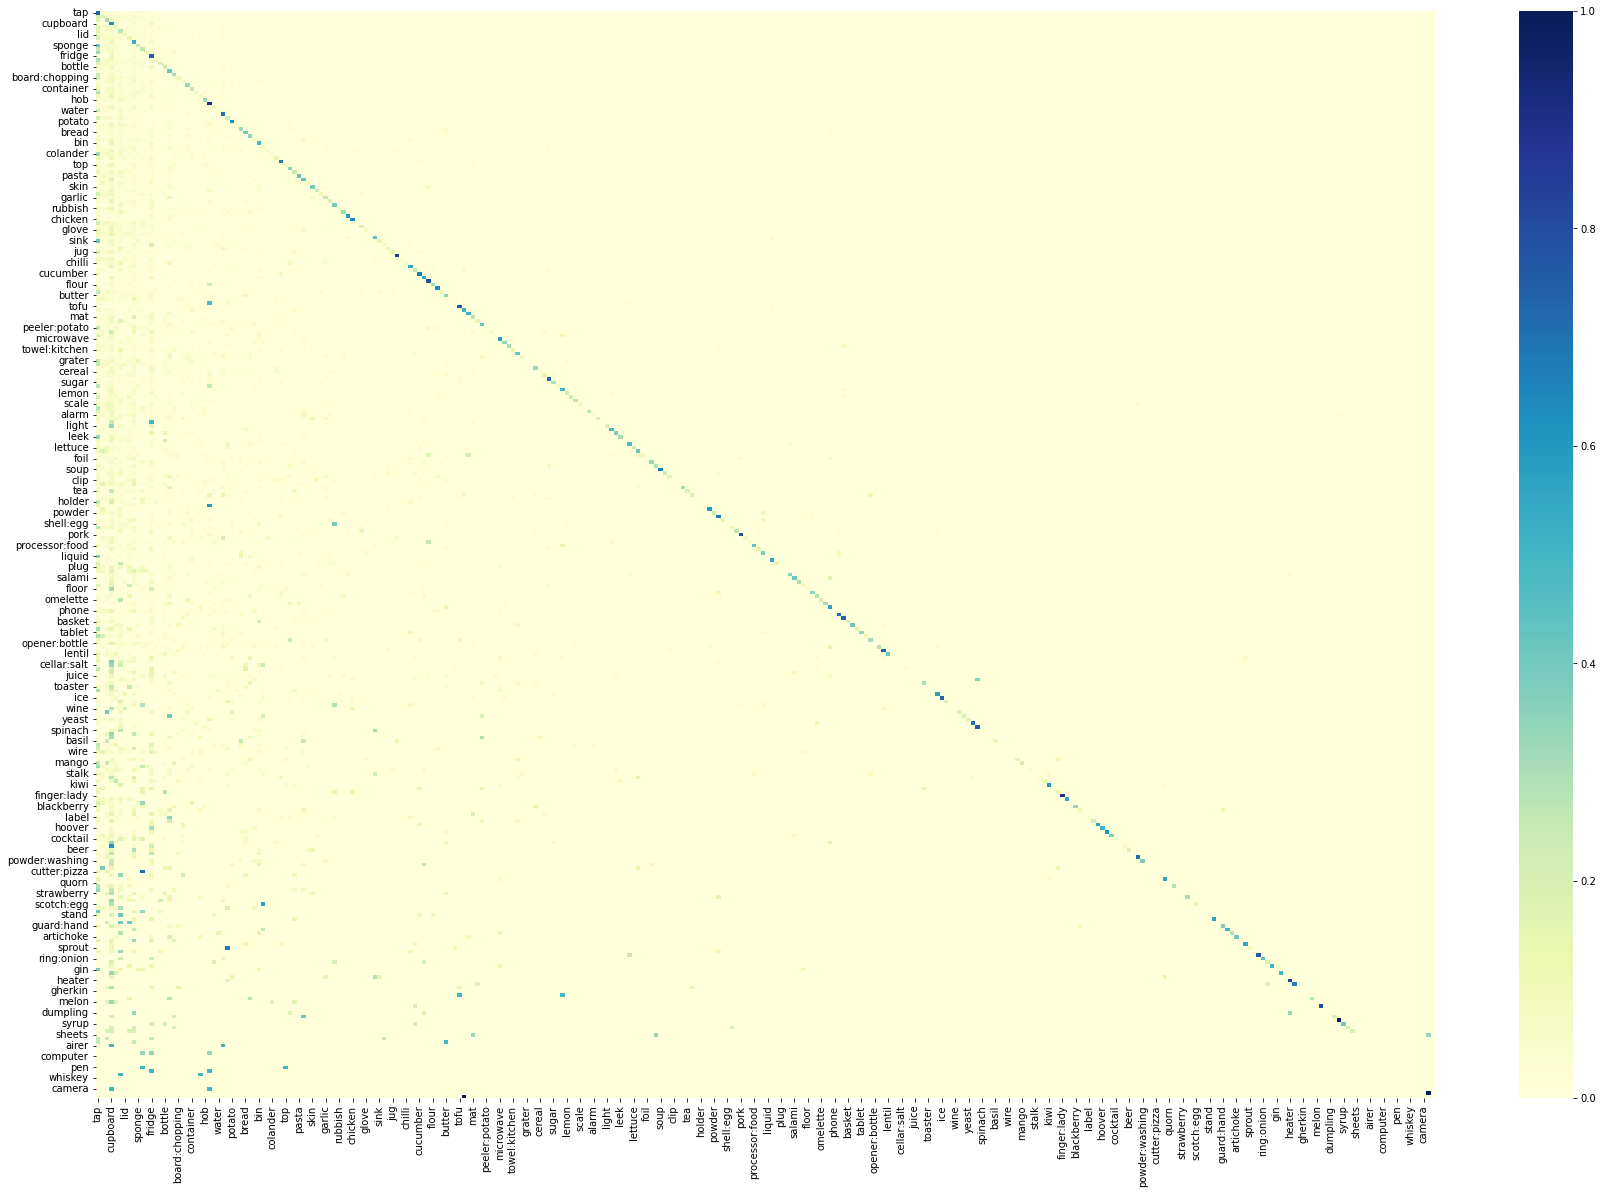

In [72]:
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(new_matrix, index = [i for i in class_list],
                  columns = [i for i in class_list])
plt.figure(figsize = (30,20))
cnf_matrix = sn.heatmap(df_cm, annot=False, cmap="YlGnBu")

In [ ]:
cnf_matrix.get_figure().savefig('conf.png', dpi=72)